# Train Test Split
Split train dataset into train, val, and test. Export a dataset from CVAT can't split automatically from tasks. So, we need to split manually if we don't specify the subsets. This notebook do that.

In [68]:
import os
import io
import yaml
import random
import shutil
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from glob import glob
from collections import Counter

Specify train, val, and test composition

In [17]:
n_train = 70
n_val = 20
n_test = 10

if sum([n_train, n_val, n_test]) != 100:
    raise ValueError("Total composition must be 100!")

In [20]:
dir_dataset = "C:/Users/eats/projects/IASS/asset/annotated/dataset-v0.3"
src_name = "data-original"
dst_name = "data"
dir_source = f"{dir_dataset}/{src_name}"
dir_output = f"{dir_dataset}/{dst_name}"

list_dir = [
    dir_source,
    dir_output,
    f"{dir_output}/images/train",
    f"{dir_output}/images/val",
    f"{dir_output}/images/test",
    f"{dir_output}/labels/train",
    f"{dir_output}/labels/val",
    f"{dir_output}/labels/test",
]
for dir in tqdm(list_dir, desc="Initialize dirs"):
    os.makedirs(dir, exist_ok=True)

list_zip = glob(f"{dir_dataset}/*.zip")
for i, path_zip in enumerate(tqdm(list_zip, desc="Extract zips")):
    # extract zip to zip directory
    with zipfile.ZipFile(path_zip, 'r') as zip_ref:
        zip_ref.extractall(dir_source)
    
    os.rename(f"{dir_source}/train.txt", f"{dir_source}/train_{i}.txt")
else:
    with open(f"{dir_source}/data.yaml", "r") as file:
        data_yaml = yaml.safe_load(file)

list_txt = glob(f"{dir_source}/*_*.txt")
all_paths_train = []
for path_txt in tqdm(list_txt, desc="Merge train.txt"):
    with open(path_txt, "r") as file:
        paths_train = file.read()
        paths_train = [item for item in paths_train.split("\n") if item]
        all_paths_train.extend(paths_train)
    os.remove(path_txt)
else:
    with open(f"{dir_source}/train.txt", "w") as file:
        file.write("\n".join(all_paths_train))


Merge train.txt: 100%|██████████| 3/3 [00:00<00:00, 88.53it/s]


In [21]:
data_yaml

{'names': {0: 'bicycle',
  1: 'motorbike',
  2: 'car',
  3: 'truck',
  4: 'bus',
  5: 'person'},
 'path': '.',
 'train': 'train.txt'}

In [24]:
all_paths_train[0]

'data/images/train/epsilon_0.jpg'

Function to split dataset into train, val, and test

In [23]:
def split_dataset(data, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, seed=None):
    if not abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6:
        raise ValueError("Ratios must sum to 1.0")
    
    if seed is not None:
        random.seed(seed)
    
    data = data.copy()
    random.shuffle(data)

    total = len(data)
    train_end = int(train_ratio * total)
    val_end = train_end + int(val_ratio * total)

    train = data[:train_end]
    val = data[train_end:val_end]
    test = data[val_end:]

    return train, val, test


In [25]:
split_train, split_val, split_test = split_dataset(all_paths_train)

len(split_train), len(split_val), len(split_test)

(3884, 1110, 556)

In [26]:
split_train[0], split_val[0], split_test[0]

('data/images/train/epsilon_977.jpg',
 'data/images/train/delta_1272.jpg',
 'data/images/train/alpha_514.jpg')

In [27]:
dataset = {
    "train": split_train,
    "val": split_val,
    "test": split_test,
}

# copy the split data to output directory
for name, list_path in dataset.items():
    for path in tqdm(list_path, desc=f"Split Images [{name}]"):
        # rename "data" (default from yaml) directory to "src_name" directory
        path = path.replace(f"data/", f"{src_name}/")
        
        # create source and destination of images path
        path_src_img = f"{dir_dataset}/{path}"
        path_dst_img = path_src_img.replace(f"/{src_name}/", f"/{dst_name}/").replace("/train/", f"/{name}/")
        
        # crete source and destination of labels path
        path_src_label = path_src_img.replace("/images/", "/labels/").replace(".jpg", ".txt")
        path_dst_label = path_dst_img.replace("/images/", "/labels/").replace(".jpg", ".txt")
        
        # copy files
        shutil.copyfile(path_src_img, path_dst_img)
        if os.path.exists(path_src_label):
            shutil.copyfile(path_src_label, path_dst_label)

# create txt file related to the split data
name = "train"
with open(f"{dir_output}/{name}.txt", "w") as file:
    file.write("\n".join([item.replace("train", name) for item in split_train]))

name = "val"
with open(f"{dir_output}/{name}.txt", "w") as file:
    file.write("\n".join([item.replace("train", name) for item in split_val]))

name = "test"
with open(f"{dir_output}/{name}.txt", "w") as file:
    file.write("\n".join([item.replace("train", name) for item in split_test]))

# create yaml file related to the split date
data_yaml["path"] = "data"
data_yaml["val"] = "val.txt"
data_yaml["test"] = "test.txt"
with io.open(f"{dir_output}/data.yaml", 'w', encoding='utf8') as file:
    yaml.dump(data_yaml, file, default_flow_style=False, allow_unicode=True)

Split Images [test]: 100%|██████████| 556/556 [00:01<00:00, 415.41it/s]


In [72]:
dir_output

'C:/Users/eats/projects/IASS/asset/annotated/dataset-v0.3/data'

In [80]:
shutil.make_archive(dir_output, "zip", dir_output)

'C:\\Users\\eats\\projects\\IASS\\asset\\annotated\\dataset-v0.3\\data.zip'

### View Split-Dataset Distribution
If the split-dataset is not balance by default, then balance it!

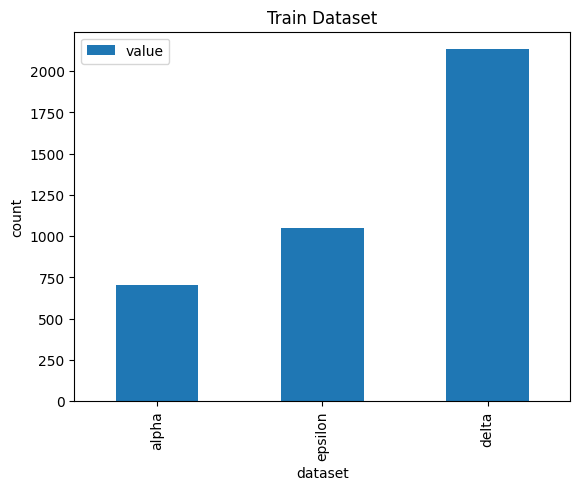

In [69]:
data = Counter([os.path.splitext(os.path.basename(item))[0].split("_")[0] for item in glob(f"{dir_output}/images/train/*")])
df = pd.DataFrame({"name": data.keys(), "value": data.values()})

df.sort_values(by="value").plot(kind="bar", x="name", xlabel="dataset", y="value", ylabel="count", title="Train Dataset")
plt.show()

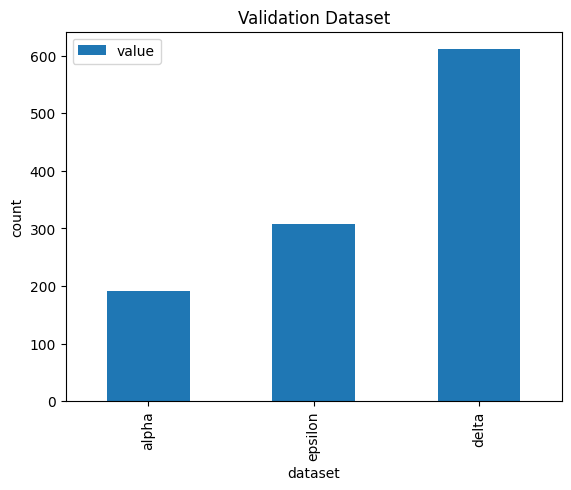

In [70]:
data = Counter([os.path.splitext(os.path.basename(item))[0].split("_")[0] for item in glob(f"{dir_output}/images/val/*")])
df = pd.DataFrame({"name": data.keys(), "value": data.values()})

df.sort_values(by="value").plot(kind="bar", x="name", xlabel="dataset", y="value", ylabel="count", title="Validation Dataset")
plt.show()

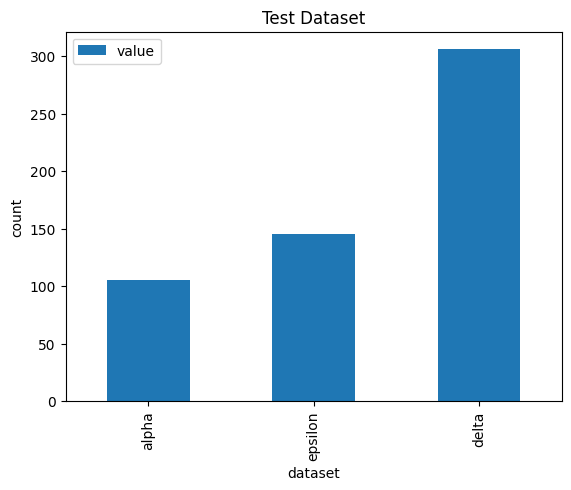

In [71]:
data = Counter([os.path.splitext(os.path.basename(item))[0].split("_")[0] for item in glob(f"{dir_output}/images/test/*")])
df = pd.DataFrame({"name": data.keys(), "value": data.values()})

df.sort_values(by="value").plot(kind="bar", x="name", xlabel="dataset", y="value", ylabel="count", title="Test Dataset")
plt.show()